# Global Precipitation Nowcasting of Integrated Multi-satellitE Retrievals for GPM: A U-Net Convolutional LSTM Architecture

This notebook uses the trained GENESIS models for global precipitation nowcastiong up to 4 hours. It contains the following sections:
1) Reading one full size input/output block. 

2) Creating patches with spatial size of 256*256 with 50% overlap and predictiong precipitation for each of them.

3) Reconstructing the entire domain by only considering interior 128*128 pixles.

4) Visualizing the global nowcasting results.

### Step 1) Reading the input/output in the original size

You can find all the used functions in the *utils.py* file.

In [1]:
# Loading the necessary packages

import os
import re
import numpy as np
from scipy import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from utils_ import *

2024-01-24 12:24:04.257518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Here we setting up GPU. It is not necessary step.
tf.config.optimizer.set_experimental_options({"layout_optimizer": False})

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
# Here we read one sample with spatial size of 1200*3600, that has three matrices in it including X(input), y(output), and GFS

current_directory = os.getcwd()
subfolder = "data/sample"
path_file = os.path.join(current_directory, subfolder)
#path = "/panfs/jay/groups/0/ebtehaj/rahim035/paper_2/V2/github_nowcast/data"
mat_files = [
    f"{path_file}/{x}" for x in os.listdir(path_file)
    if re.match(r".*\.mat", x)
]


### Step 2) Creationg 256*256 patches

In [ ]:
# Here we create patches with spatila size 256*256 and 50% overlap to be fed to the network and save them in a seprate folder
patches = patchify_seq(mat_files, 256, 128, path_file)

In [4]:
# Here we load mean, and standard deviation for narmalizing the inputs, and class_weights to use for focal loss
subfolder = "data/"
path_data = os.path.join(current_directory, subfolder)
class_weights = np.load(path_data + "class_weights.npy", allow_pickle=True)
stat = io.loadmat(path_data + "stat.mat")
mean_x = np.mean(stat["mean_x"],axis = 0)
std_x  = np.mean(stat["std_x"],axis = 0)
std = np.transpose(std_x)
mu = np.transpose(mean_x)


# Here we load the trained models
#%% Loading the GENESIS_MSE model
subfolder = "GENESIS_models/"
path_models = os.path.join(current_directory, subfolder)
save_name_genesis_mse = f"GENESIS_MSE"
load_path_genesis_mse = f"{path_models}/{save_name_genesis_mse}.h5"
genesis_mse = tf.keras.models.load_model(load_path_genesis_mse)

#%% Loading the GENESIS_Fl model and compiling it beacuse of the defined focal loss
save_name_genesis_fl = f"GENESIS_FL"
load_path_genesis_fl = f"{path_models}/{save_name_genesis_fl}.h5"
genesis_fl = tf.keras.models.load_model(load_path_genesis_fl, custom_objects={'CategoricalFocalLoss': CategoricalFocalLoss(alpha=class_weights, gamma=2)}, compile=False)
loss=[CategoricalFocalLoss(alpha=class_weights, gamma=2)]
genesis_fl.compile(
     loss=loss,
     optimizer=keras.optimizers.Adam(learning_rate=0.0001),
     metrics=[tf.keras.metrics.Recall()])


In [5]:
current_directory = os.getcwd()
subfolder = "data/sample"
path = os.path.join(current_directory, subfolder)
directory = 'sample_'+str(0)
test_directory = os.path.join(path, directory) 
test_paths = [f"{test_directory}/{x}" for x in os.listdir(test_directory)]
len(test_paths)

252

### Step 3) Predicting precipitation field for each patch with 4-hour lead time and reconsturct the original field.

In [6]:
# Here we predict precipitation field for the next 4-hour for each patch

i = 0
bins_num = 9 
current_directory = os.getcwd()
subfolder = "data/sample"
path = os.path.join(current_directory, subfolder)
directory = 'sample_'+str(i)
test_directory = os.path.join(path, directory) 
test_paths = [f"{test_directory}/{x}" for x in os.listdir(test_directory)]

# Prediction
## regression model
test_dataset_reg = CustomGenerator_reg(test_paths,  mu, std, 1, shuffle=False)
pred_genesis_mse = genesis_mse.predict(test_dataset_reg)

## classification model
test_dataset_class   = CustomGenerator_class(test_paths,  mu, std, 1, bins_num, shuffle=False)
pred_genesis_fl = genesis_fl.predict(test_dataset_class)
pred_genesis_fl = np.argmax(pred_genesis_fl,axis = -1)

# Loading the observed data
obs_mse = []
gfs_mse = []
obs_fl  = []
gfs_fl  = []

for k in range(252):
    X_mse, y_mse= test_dataset_reg.__getitem__(k)
    y_mse = y_mse[0]
    obs_mse.append(y_mse)
    
    X_fl, y_fl= test_dataset_class.__getitem__(k)
    y_fl = y_fl[0]
    y_fl = np.argmax(y_fl, axis = -1)
    obs_fl.append(y_fl)
    
obs_mse = np.array(obs_mse)
obs_fl  = np.array(obs_fl)

# Here we merge the predicted patches to reconstruc the orginal spatial domain by only considering 128*128 interior pixels.

observation_mse = merge_patches_v2(obs_mse, [256,256], 0.5, 64, [128,128], [8,1280,3712], [8,1200,3600])
prediction_mse  = merge_patches_v2(pred_genesis_mse, [256,256], 0.5, 64, [128,128], [8,1280,3712], [8,1200,3600])

observation_fl  = merge_patches_v2(obs_fl, [256,256], 0.5, 64, [128,128], [8,1280,3712], [8,1200,3600])
prediction_fl   = merge_patches_v2(pred_genesis_fl, [256,256], 0.5, 64, [128,128], [8,1280,3712], [8,1200,3600])

bins = pow(10,np.linspace(np.log10(0.10), np.log10(32), bins_num))

observation_mse = np.digitize(observation_mse, bins)   # classes ranges from 0 to bin_num
prediction_mse = np.digitize(prediction_mse, bins)   # classes ranges from 0 to bin_num

252/252 [==============================] - 51s 181ms/step


2024-01-24 12:25:58.145790: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5284823040 exceeds 10% of free system memory.


### Step 4) Visualizing the results

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

In [8]:
# load the coordination
coord = io.loadmat(path_data + "/coordination.mat")
lat = coord['lat']
lon = coord['lon']

# load the colormap
cmap = io.loadmat(path_data + "/colormap.mat")
cmap = cmap["Cmap_rain"]
newcmp = ListedColormap(cmap)

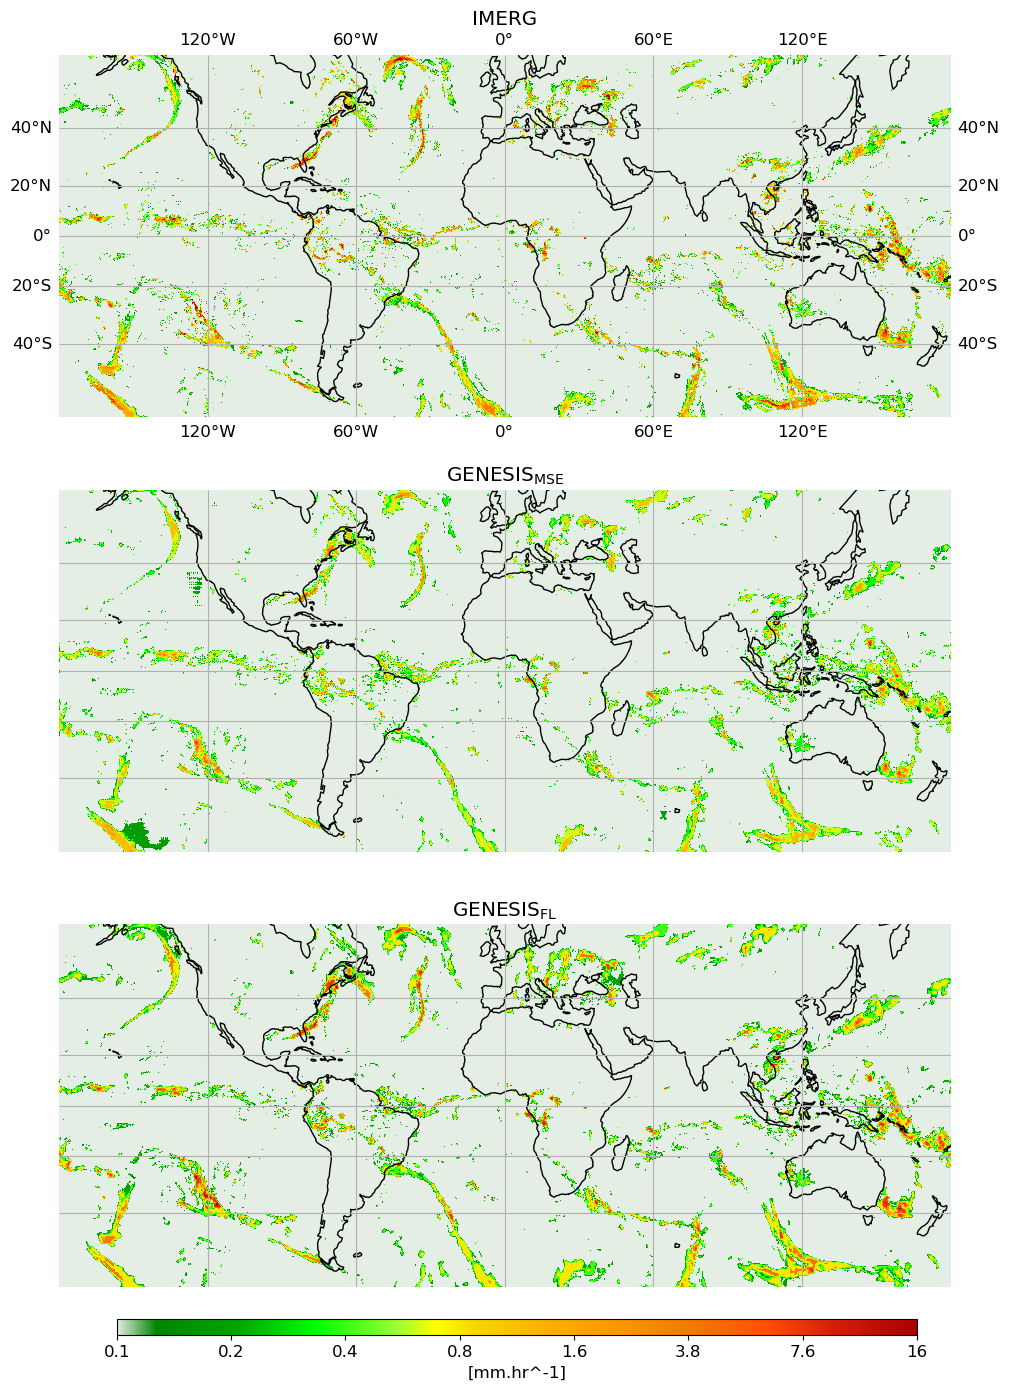

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np

plt.rcParams['font.size'] = 12

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(3, 1, figure=fig)

# Data and titles for each subplot (replace with actual data and titles)
data = [observation_mse[0, :, :], prediction_mse[0, :, :], prediction_fl[0, :, :]]
titles = ['IMERG', r'$\rm GENESIS_{MSE}$', r'$\rm GENESIS_{FL}$']

# Subplot 1- Observation
ax1 = plt.subplot(gs[0], projection=ccrs.Mercator())
plot1 = ax1.pcolormesh(lon, lat, np.squeeze(data[0]), vmin=1, vmax=8, cmap=newcmp, transform=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(draw_labels=True)
ax1.set_extent([-180, 180, -59, 59], ccrs.PlateCarree())
ax1.spines['geo'].set_visible(False)
ax1.set_title(titles[0])

# Subplot 2- GENESIS MSE
ax2 = plt.subplot(gs[1], projection=ccrs.Mercator())
plot2 = ax2.pcolormesh(lon, lat, np.squeeze(data[1]), vmin=1, vmax=9, cmap=newcmp, transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.gridlines(draw_labels=False)
ax2.set_extent([-180, 180, -59, 59], ccrs.PlateCarree())
ax2.spines['geo'].set_visible(False)
ax2.set_title(titles[1])

# Subplot 3- GENESIS FL
ax3 = plt.subplot(gs[2], projection=ccrs.Mercator())
plot3 = ax3.pcolormesh(lon, lat, np.squeeze(data[2]), vmin=1, vmax=8, cmap=newcmp, transform=ccrs.PlateCarree())
ax3.coastlines()
ax3.gridlines(draw_labels=False)
ax3.set_extent([-180, 180, -59, 59], ccrs.PlateCarree())
ax3.spines['geo'].set_visible(False)
ax3.set_title(titles[2])

# Adding colorbar
cax = fig.add_axes([0.27, 0.08, 0.5, 0.01])
cbar = plt.colorbar(plot3, cax=cax, orientation="horizontal", ticks=np.arange(1, 9, 1))
cbar.ax.set_xticklabels(['0.1', '0.2', '0.4', '0.8', '1.6', '3.8', '7.6', '16'])
cbar.set_label('[mm.hr^-1]', fontsize=12)

plt.show()
